### Refs

https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

https://surfertas.github.io/tensorflow/dl/2018/01/24/tf-data-augmentation.html

In [1]:
import tensorflow as tf

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.8.0


### Image dimesion

In [3]:
HEIGHT = 128
WIDTH = 128

### Aux function to show a batch

In [4]:
def show_batch(image_batch, label_batch, epoch):
  columns = 5
  rows = BATCH_SIZE / columns + 1  
  epochImages = plt.figure(figsize=(15, 3 * rows))
  epochImages.suptitle('epoch {}'.format(epoch))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


### Auxiliary functions to load image

In [5]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Function to process images

In [6]:
import tensorflow_addons as tfa

def process_image(image, label):
    
    #image = tf.image.resize(image, (64,64))
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5) - 0.25
    image = tfa.image.rotate(image, r)
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])
    #image = tfa.image.random_hsv_in_yiq(image, 0.5, 0.9, 1.1, 0.9, 1.3)
    #image = tf.image.resize(image, (32,32))
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 
                    0.4,
                    0.4,1.4,
                    0.4, 1.4), 0.0, 1.0)
    return image, label

### CONVERT PPM TO JPG

In [7]:
from PIL import Image
import os

directory = "C:/Users/obsession/Desktop/Data Augmentation/DatasetProjeto/train_images/GTSRB/Final_Training/Images/"

for root, subdirectories, files in os.walk(directory):
    for subdirectory in subdirectories:
        continue
        #print(os.path.join(root, subdirectory))
    for file in files:
        if file.endswith("ppm"):
            #print(file)
            img = Image.open(os.path.join(root, file))
            img.save(os.path.join(root, file)+".jpg")
        #print(os.path.join(root, file))



### Prepare dataset

In [29]:
BATCH_SIZE = 10

data_dir = pathlib.Path('C:/Users/obsession/Desktop/Data Augmentation/DatasetProjeto/train_images/GTSRB/Final_Training/Images')
classNames = np.array(os.listdir(data_dir))
#print(classNames)

AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("C:/Users/obsession/Desktop/Data Augmentation/DatasetProjeto/train_images/GTSRB/Final_Training/Images/*/*.jpg")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.map(process_image)
# shuffle elements, to shuffle batches place shuffle after batch
dataset = dataset.shuffle(10)
dataset = dataset.batch(batch_size = BATCH_SIZE)
#dataset = dataset.repeat()

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: C:/Users/obsession/Desktop/Data Augmentation/DatasetProjeto/train_images/GTSRB/Final_Training/Images/*/*.jpg'

## Show images for three epochs

In [17]:

image_batch, label_batch = next(iter(dataset))        
show_batch(image_batch, label_batch.numpy(), 1)

image_batch, label_batch = next(iter(dataset))      
show_batch(image_batch, label_batch.numpy(), 2)

image_batch, label_batch = next(iter(dataset))      
show_batch(image_batch, label_batch.numpy(), 3)


InvalidArgumentError: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodePng}}]] [Op:IteratorGetNext]

### Define simpler functions for data augmentation

In [12]:
def process_image_trans(image, label):
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])

    return image, label

def process_image_rot(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5, dtype=tf.dtypes.float32) - 0.25
    image = tfa.image.rotate(image, r)
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1), 0.0, 1.0)

    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=0.1)-0.2),0,1)
    return image, label

## Create a dataset with twice the number of images, one subset is translated, the other is rotated

In [13]:
BATCH_SIZE = 20

datasetA = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetA = datasetA.prefetch(buffer_size=AUTOTUNE)
datasetB = datasetA.map(process_image_trans)
datasetB = datasetB.concatenate(datasetA.map(process_image_rot))
datasetB = datasetB.shuffle(20)
datasetB = datasetB.batch(batch_size = BATCH_SIZE)
#datasetB = datasetB.repeat()


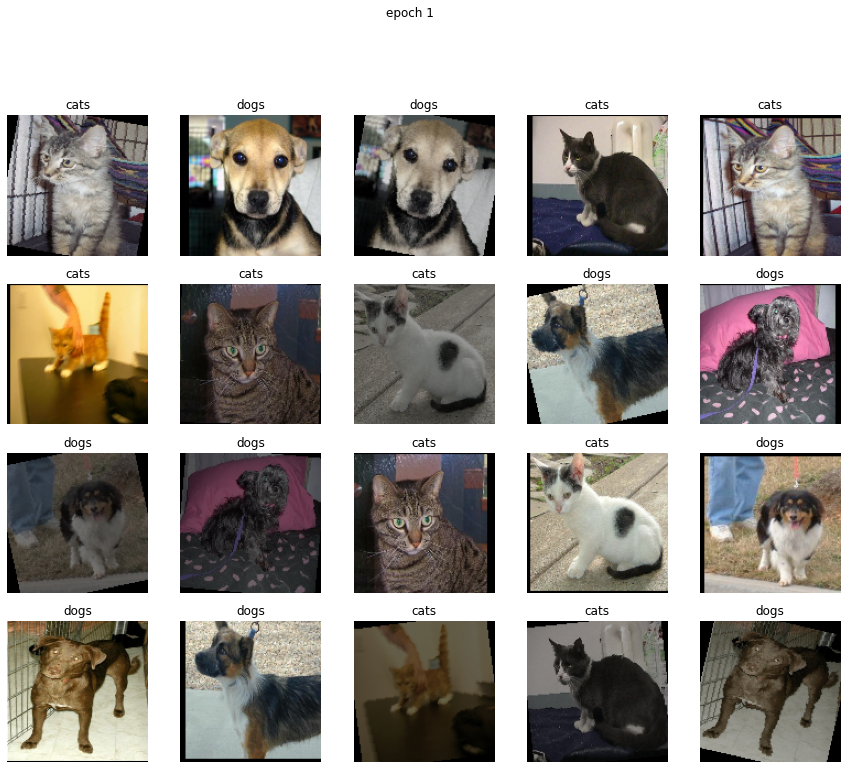

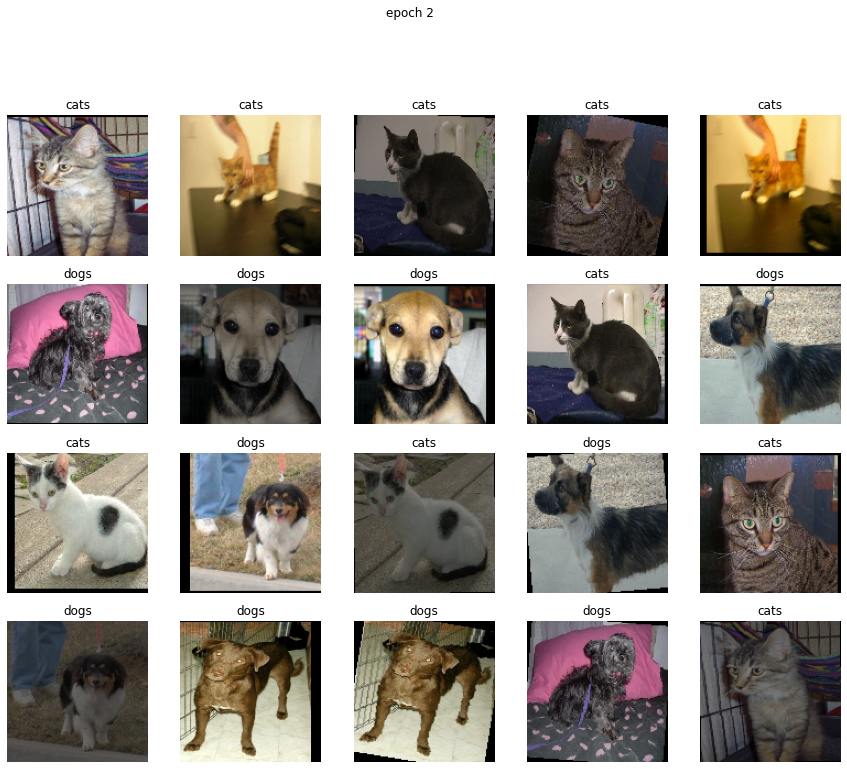

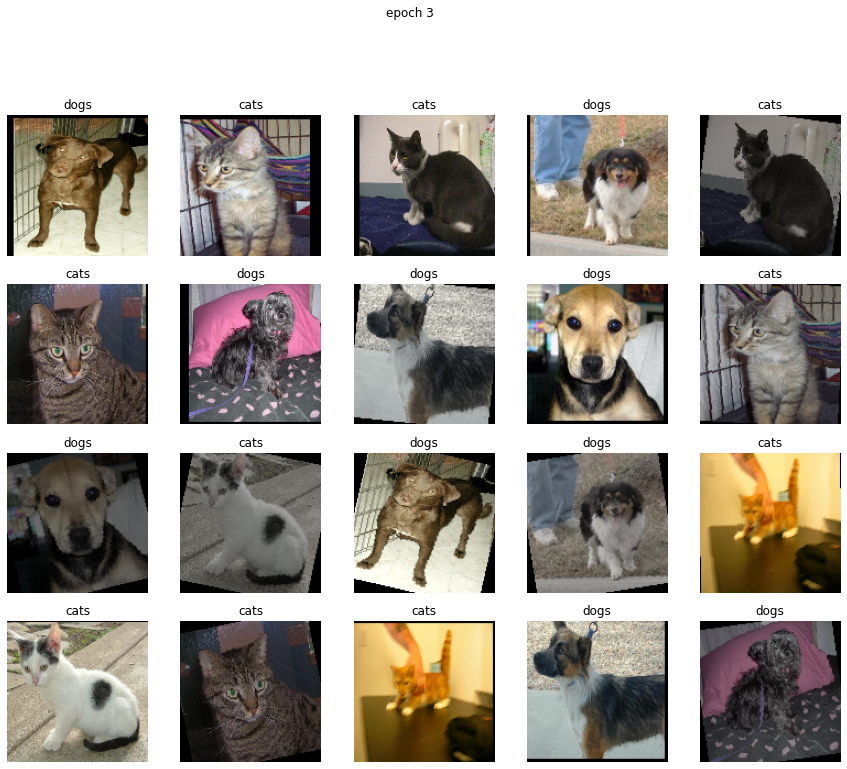

In [14]:
image_batch, label_batch = next(iter(datasetB))        
show_batch(image_batch, label_batch.numpy(), 1)
image_batch, label_batch = next(iter(datasetB))      
show_batch(image_batch, label_batch.numpy(), 2)
image_batch, label_batch = next(iter(datasetB))      
show_batch(image_batch, label_batch.numpy(), 3)
